为了熟悉深度神经网络的构建和调参，本人以推荐系统为具体实验对象，以 番组计划（bangumi.tv）上的评分数据为基础做了一些实验工作，以期建立一个实用的动画推荐系统。推荐系统在学术和商用上都发展了很长的时间，也涌现出了很多优秀的算法。囿于本人能力和精力有限，对推荐系统涉及到的各方面的知识只是浅尝辄止，如果文中表述有误或者你有什么建议，都非常欢迎留言讨论。你也可以在项目里找到包括文中涉及到的数据以及代码等相关信息。

本文首先简单介绍了推荐系统的几种主要的实现方式，然后介绍了基于矩阵分解的推荐系统及相关的一个实验，接着介绍了使用深度学习构建的推荐模型在学术集上取得了接近state-of-the-art的实验结果以及模型在Bangumi数据集上的应用，然后尝试参考Word2vec思想来优化深度网络，最后介绍了利用得到的模型来构建推荐系统以及对知名网站推荐系统的调研和一个基于内容推荐的算法设计思路。

###推荐系统研究现状

推荐系统一般是以用户的历史操作信息来为不同用户定制符合其需求的个性化服务。推荐系统可能的输入数据及其形式多种多样，归纳起来一般可以分为用户、物品和评价三个方面，如果用矩阵来表示则分别对应一个矩阵中的行、列和值。推荐系统的输出一般是一个个性化的推荐列表，按优先级的顺序给出该用户可能感兴趣的物品。依据推荐方法的不同，推荐算法大致可以分为：基于内容的推荐、基于协同过滤的推荐和混合型推荐系统。其中基于协同过滤的推荐被研究的最为深入，它又可以分为基于用户的推荐，基于物品的推荐和基于模型的推荐等<sup>[1]</sup>。

###基于矩阵分解的评分预测

一个典型的推荐系统常常把用户和物品之间的关系形式化为一个稀疏矩阵，其中矩阵每一行对应一个用户，每一列对应一个物品，矩阵的每一个非零值代表相应的用户对物品的打分，而每一个零值则代表用户没有对该物品进行过评分。基于矩阵分解的矩阵补全由于其较好的预测精度和较高的可扩展性，故在推荐系统中得到了广泛的应用。例如矩阵的奇异值分解（Singular Value Decomposition, SVD），非负矩阵分解（Non-negative Matrix Factorization, NMF）等等。由于基于矩阵分解的推荐系统不是本文的研究重点，这里只简要介绍一下SVD的原理和我使用SVD所做的一个实验。

在一切开始之前，我们首先需要定义合适的评价指标来评价一个算法的预测结果，常用的评价指标有根分均方差（Root Mean Square Error, RMSE）和平均绝对误差（Mean Absolue Error, MAE），这两个评价指标在下文评价深度学习模型时也会用到，其计算方式本文不再赘述。

最原始的矩阵奇异值分解方法具有严格的数学定义，设$X\in R^{m\times n}$是任意矩阵，矩阵$U\in R^{m\times r}$中的列向量是矩阵$XX^{T}\in R^{m\times m}$的单位正交特征向量，矩阵$V\in R^{n\times r}$中的列向量是矩阵$X^{T}X\in R^{n\times n}$的单位正交特征向量，对角矩阵$S\in R^{r\times r}$的每一个对角元素$\sqrt{\sigma}$则是与矩阵$U$（同时也是与矩阵$V$）中的每一个列向量对应的特征值$\sigma$的平方根，并以从大到小的顺序排列，则原矩阵$X$则可表示为$X=US V^{T}$，其中$S$被称为奇异值矩阵。如果我们只保留奇异值矩阵$S$中的前$k$个最大的奇异值，同时只保留$U$和$V$中的前$k$个对应的列向量，则新的矩阵$\hat{X}=U_{k}S_{k}V_{k}^{T}$即为对原矩阵$X$的一个近似[2]。可以证明，对原矩阵$X$所有秩为$k$的近似中，采用如上SVD得到的近似结果可以取得到最小的平方误差，即：$$\hat{X}=U_{k}S_{k}V_{k}^{T}=argmin_{rank(\hat{X})=k}||X-\hat{X}||_{Fro}^{2}$$

显然，通过这种方式取得的近似矩阵也就具有最小的RMSE值。下图是文献[2]中的插图，图中描述与上文略有出入，但表达的算法是一样的。
<img src="http://wx1.sinaimg.cn/large/0062shohly1fr5emw5nkcj30kr0bmq53.jpg" style="zoom:80%"/>
<center>图1 矩阵$X$奇异值分解示意图</center>

然而在实际推荐系统中，我们所要处理的往往是非常稀疏的矩阵，即矩阵中存在大量的未知打分（以0值表示）。因此在计算预测精度时，将这些元素上的预测值也考虑在内并以0作为真实值进行评测是不合理的。

基于这一事实，实际推荐系统中所使用的的SVD算法并不是原始的SVD，而是只考虑已观测数据进行模型训练和预测的SVD算法，并采用优化的方法求得近似矩阵以应对大规模的稀疏矩阵。优化的方法比较多，往往比较复杂，本文在实验时采用的是文献[3]中介绍的处理办法：首先计算矩阵$X$中每行和每列的平均值，将矩阵中的缺失元素用该元素所在列的平均值代替,得到填充矩阵，然后将填充矩阵中所有元素减去其所在行的平均值，得到规范化矩阵$X_{norm}$。本实验借用numpy中的linalg模块来实现SVD。

在实验正式开始之前，我们先分析一下Bangumi上的评分数据情况。

数据是5月6号爬的。可以在下面看到在去掉没有评分操作的用户和没有被评分过的条目之后，一共有51570个用户和11324个条目。

In [6]:
# svd.py
import numpy as np
from numpy import linalg
import pandas as pd
import seaborn

data = pd.read_csv('./bgmdata/ratings.txt', sep=' ', engine='python', names=['uid', 'sid', 'rating']) # read data from file
n_user = data.uid.unique().shape[0] # number of users
n_sub = data.sid.unique().shape[0] #  number of subjects
print n_user, n_sub

51570 11324


数据是经过预处理的，用户和条目都被重新编号，评分是1~10的整数。

In [7]:
data.head()

,uid,sid,rating
0,0,0,2
1,1,0,8
2,2,0,1
3,3,0,1
4,4,0,6


一共有约318万条评分数据。评分的平均数是7.2,7分是最经常被评的分数，我们也可以从下面的直方图更加直观地看到评分数据分布情况。

In [8]:
data.rating.describe()

count    3.177697e+06
mean     7.199741e+00
std      1.522199e+00
min      1.000000e+00
25%      6.000000e+00
50%      7.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

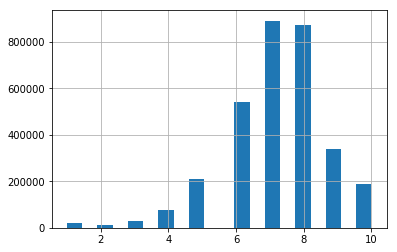

In [9]:
data.rating.hist(bins=20)

这个是所有用户评分情况的统计数据，可以看到平均每个用户有62个评分操作，大部分用户只有6个评分操作。这也说明了评分矩阵是很稀疏的，下面的直方图可以更加直观地看到数据分布情况。

In [10]:
data.uid.value_counts().describe()

count    51570.000000
mean        61.619100
std        149.706687
min          1.000000
25%          1.000000
50%          6.000000
75%         46.000000
max       3839.000000
Name: uid, dtype: float64

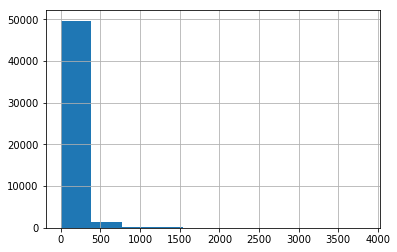

In [21]:
data.uid.value_counts().hist()

下面是上文描述算法的实现代码。这是个很粗糙的利用SVD算法实现的推荐系统，不仅需要大量的计算，而且我粗略地检查了推荐结果后发现效果比较差。

In [ ]:
X = np.zeros((n_user, n_sub), dtype='float64') # rating matrix
f = open('ratings.txt')
for line in input:
    line = line.strip('\r\n').split(' ')
    uid = int(line[0])
    sid = int(line[1])
    rating = float(line[2])
    X[uid, sid] = rating
sub_avg = [] # subject average rating
for i in range(n_sub):
    sub_avg.append(np.sum(X[:, i]) / np.count_nonzero(X[:, i]))
for i in range(n_user):
    for j in range(n_sub):
        if X[i, j] == 0:
            X[i, j] = sub_avg[j]
for i in range(n_user):
    X[i] -= np.sum(X[i]) / np.count_nonzero(X[i]) # Standardized

U, S, V = linalg.svd(X)

recommend = [[] for i in range(n_sub)]
for i in range(n_sub):
    for j in range(n_sub):
        if i == j:
            continue
        vi = V[:, i]
        vj = V[:, j]
        recommend[i].append([j, np.dot(vi, vj) / (linalg.norm(vi) * linalg.norm(vj))]) # cosine similarity

out = open('./save/svd_recommend.txt', 'w')
for i in range(n_sub):
    recommend[i] = sorted(recommend[i], key=lambda x: x[1], reverse=True)
    s = ''
    topn = min(20, len(recommend[i])) # top 20
    for j in range(topn):
        s += str(recommend[i][j][0]) + ' ' + str(recommend[i][j][1]) + ','
    s = s[:-1]
    out.write(s + '\n')
out.close()

###基于深度学习的评分预测
由于SVD并不是本文重点，而且很多论文中提出的算法不容易实现，我也没有去计算上述实现的RMSE。下面的内容主要围绕使用深度学习构建的神经网络模型展开。

这里使用Kears框架。机器学习我也接触一两年了，在外面实习和在学校实验室里使用过几种框架，包括Caffe和TensoFlow等，但缺点是都不太好写。Keras一直以其简单好用而著名，前段时间也有了中文文档。当然PyTorch也很有名，更加适合学术研究，之后有机会再学学。

我们先在著名的学术集MovieLens 1M Dataset<sup>[4]</sup>（以下简称mldata）测试模型的准确率，之后再考虑应用到Bangumi数据上。
mldata是一个电影评分数据集，我们首先来分析一下mldata的分布情况。

从下面可以看到这个数据集有6040个用户，3706个电影，数据集里还包含了评分时间这一列，但是这里我们用不到。

In [2]:
# ml-dot.py
from keras.models import Sequential, Model, Input
from keras.layers import Dot, Dense, Dropout, Embedding, Reshape, Conv1D, MaxPooling1D
from keras.layers.merge import Concatenate
from keras.callbacks import ModelCheckpoint
from keras import metrics, utils, losses
from keras.utils.vis_utils import model_to_dot
from sklearn import metrics as sk_metrics, cross_validation
from IPython.display import SVG
import matplotlib.pyplot as plt
from pylab import plot
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')

k = 128
data = pd.read_csv('./mldata/ratings.dat', sep='::', engine='python', names=['uid', 'sid', 'rating', 'time'])
n_user = data.uid.unique().shape[0]
n_sub = data.sid.unique().shape[0]
print n_user, n_sub

6040 3706


mldata的用户和电影的id都是从1开始编号的，而且是五分制，也就是说评分是1~5的整数。

In [23]:
data.head()

,uid,sid,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


这里可以看到mldata一共有100万条评分数据，这也是MovieLens 1M Dataset中"1M"的来源，类似的还有别的大小的数据集。平均评分是3.6，4分占比最大。与上面提到的Bangumi的评分数据对比来看，mldata相对没有那么稀疏，而且五分制相对十分制而言评分的噪声也会要小一些。

In [24]:
data.rating.describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

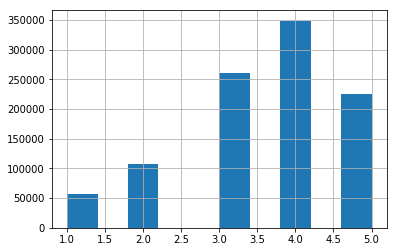

In [18]:
data.rating.hist(bins=10)

In [26]:
data.uid.value_counts().describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: uid, dtype: float64

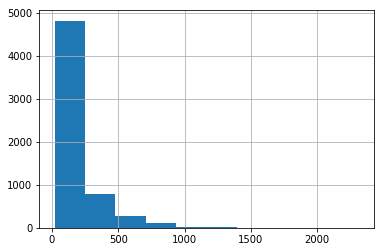

In [27]:
data.uid.value_counts().hist()

接下来我们开始构建网络。首先想到的网络就是模拟矩阵分解的思想：首先对每个用户和条目进行embedding，然后让表示用户的向量（$1\times k$）与表示条目的向量（$k\times 1$）相乘，乘积结果与实际评分做误差反向传播，更新embedding层的参数。

这个网络非常简单，下面是用Kears构建网络的代码和网络结构图。这里loss function我们选择的是MSE，与上文提到的RMSE区别就在于后者多了一次开根运算，optimizer选择的是常用的Adam。

这里的$k$是embedding的size，可以自己设定，视机器硬件条件和数据集大小设为几十到几百都可以。我在实验中发现$k$值适当大一些训练效果会更好，但是过大的话不会继续提升准确率反而影响训练速度，这也是符合常识的。

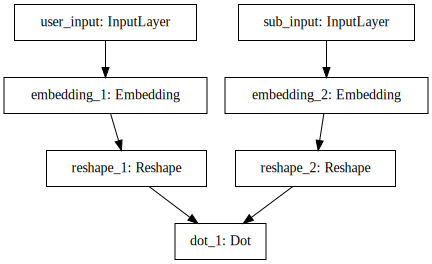

In [8]:
input1 = Input(shape=(1,), name='user_input')
model1 = Embedding(n_user, k, input_length=1)(input1)
model1 = Reshape((k,))(model1)
input2 = Input(shape=(1,), name='sub_input')
model2 = Embedding(n_sub, k, input_length=1)(input2)
model2 = Reshape((k,))(model2)
output = Dot(axes=1)([model1, model2])
model = Model([input1, input2], output)
model.compile(loss='mse', optimizer='adam')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

接下来是模型训练过程，我们首先把数据集分成训练集和测试集。由于评分矩阵比较稀疏，为了减少调参时每次随机划分测试集导致计算的loss浮动偏大的问题，我们在这里固定随机种子。

这里我把batch_size设为500，训练20个epochs，训练过程如下。

In [13]:
train, test = cross_validation.train_test_split(data, test_size=0.1, random_state=1)
x_train = [train.uid, train.sid]
y_train = train.rating
x_test = [test.uid, test.sid]
y_test = test.rating
history = model.fit(x_train, y_train, batch_size=500, epochs=20, validation_data=(x_test, y_test))

save_path = './save/ml-dot/'
model.save(save_path + 'model.h5')
with open(save_path + 'history.pkl', 'wb') as file_history:
    pickle.dump(history.history, file_history)

Train on 900188 samples, validate on 100021 samples
Epoch 1/20
900188/900188 [==============================] - 23s 25us/step - loss: 4.9196 - val_loss: 1.3608
Epoch 2/20
900188/900188 [==============================] - 10s 11us/step - loss: 1.3079 - val_loss: 1.2815
Epoch 3/20
900188/900188 [==============================] - 10s 11us/step - loss: 1.2316 - val_loss: 1.2492
Epoch 4/20
900188/900188 [==============================] - 10s 11us/step - loss: 1.1669 - val_loss: 1.2311
Epoch 5/20
900188/900188 [==============================] - 10s 11us/step - loss: 1.1037 - val_loss: 1.2271
Epoch 6/20
900188/900188 [==============================] - 10s 11us/step - loss: 1.0384 - val_loss: 1.2280
Epoch 7/20
900188/900188 [==============================] - 10s 11us/step - loss: 0.9720 - val_loss: 1.2395
Epoch 8/20
900188/900188 [==============================] - 10s 11us/step - loss: 0.9092 - val_loss: 1.2566
Epoch 9/20
900188/900188 [==============================] - 10s 11us/step - loss: 0.

这个是训练中的loss变化表，第一行为训练loss，第二行为测试loss，我们主要关注测试loss的走势。

In [14]:
pd.DataFrame(history.history, columns=['loss', 'val_loss']).head(20).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,4.919590,1.307881,1.231598,1.166876,1.103711,1.038391,0.972046,0.909158,0.853612,0.808019,0.772006,0.743751,0.722089,0.704995,0.691228,0.680220,0.670842,0.663113,0.656333,0.650621
val_loss,1.360837,1.281529,1.249161,1.231100,1.227113,1.227963,1.239482,1.256634,1.281175,1.306556,1.334485,1.363756,1.389600,1.417761,1.441684,1.467355,1.489836,1.512855,1.535828,1.557300


这张图可以更为直观地看到实际上我们的测试loss在第5个epoch就已经达到最低了，之后已经过拟合了。

(0, 3)

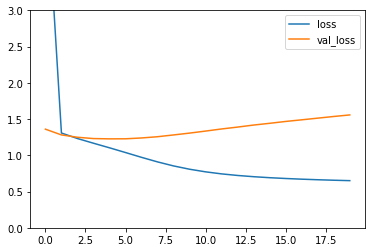

In [19]:
plot(history.history['loss'], label='loss')
plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.ylim(0, 3)

上面的实验尝试用神经网络模拟矩阵分解，网络结构很简单，最后的MSE loss为1.23，实际上这个结果并不好。接下来我们尝试改变用户与条目embedding的结合方式，在网络中加入更多隐藏层，以及使用Dropout层以防止过拟合，从而构建一个深度网络。然后比较我们的结果与state-of-the-art实验结果作对比，从而证实这个深度网络是有效的。

读入数据和分析数据部分与上面一致，这里略去。在embedding之后，这里我们使用Concatenate连接层，用来将用户向量和条目线性连接为一个大小为$1\times 2k$的向量。接下来连接3个Dense全连接层，全连接层的大小逐渐减小，最后再与一个大小为1的全连接层连接用于得到预测结果。中间穿插了一些Drop层用于防止过拟合。由于预测结果为单个浮点数，所以激活函数我们这里都是选择线性函数，之后的实验我们也会尝试使用非线性函数用作对比。

另外评估方式我们又增加了MAE（平均绝对误差）和ACC（准确率），其计算方式这里不再赘述。

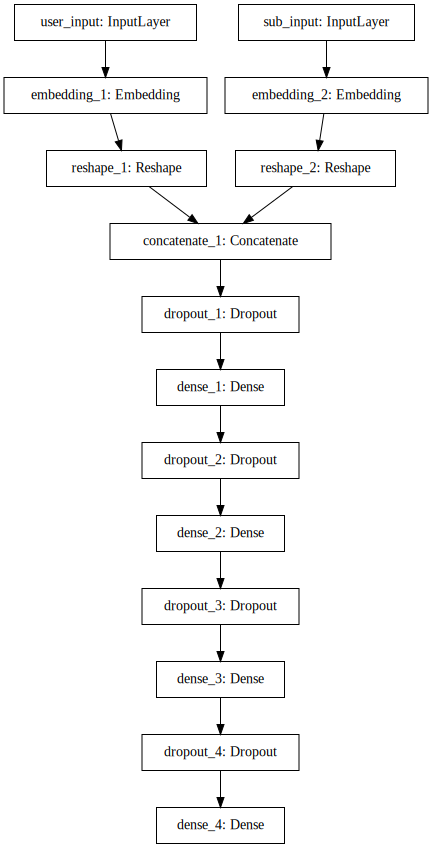

In [3]:
# ml-deep.py
input1 = Input(shape=(1,), name='user_input')
model1 = Embedding(n_user, k, input_length=1)(input1)
model1 = Reshape((k,))(model1)
input2 = Input(shape=(1,), name='sub_input')
model2 = Embedding(n_sub, k, input_length=1)(input2)
model2 = Reshape((k,))(model2)
model = Concatenate()([model1, model2])
model = Dropout(0.2)(model)
model = Dense(k, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(int(k/4), activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(int(k/16), activation='relu')(model)
model = Dropout(0.5)(model)
output = Dense(1, activation='linear')(model)
model = Model([input1, input2], output)
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'acc'])
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [4]:
train, test = cross_validation.train_test_split(data, test_size=0.1, random_state=1)
x_train = [train.uid, train.sid]
y_train = train.rating
x_test = [test.uid, test.sid]
y_test = test.rating
history = model.fit(x_train, y_train, batch_size=500, epochs=20, validation_data=(x_test, y_test))

save_path = './save/ml-deep/'
model.save(save_path + 'model.h5')
with open(save_path + 'history.pkl', 'wb') as file_history:
    pickle.dump(history.history, file_history)

Train on 900188 samples, validate on 100021 samples
Epoch 1/20
900188/900188 [==============================] - 33s 37us/step - loss: 2.5244 - mean_absolute_error: 1.2707 - acc: 0.2439 - val_loss: 0.9831 - val_mean_absolute_error: 0.8232 - val_acc: 0.3516
Epoch 2/20
900188/900188 [==============================] - 17s 19us/step - loss: 1.3839 - mean_absolute_error: 0.9465 - acc: 0.3204 - val_loss: 0.8816 - val_mean_absolute_error: 0.7635 - val_acc: 0.3903
Epoch 3/20
900188/900188 [==============================] - 17s 19us/step - loss: 1.0380 - mean_absolute_error: 0.8212 - acc: 0.3673 - val_loss: 0.8941 - val_mean_absolute_error: 0.7521 - val_acc: 0.3966
Epoch 4/20
900188/900188 [==============================] - 17s 19us/step - loss: 0.9789 - mean_absolute_error: 0.7843 - acc: 0.3852 - val_loss: 0.9093 - val_mean_absolute_error: 0.7500 - val_acc: 0.3953
Epoch 5/20
900188/900188 [==============================] - 17s 19us/step - loss: 0.9709 - mean_absolute_error: 0.7775 - acc: 0.3886

从下面的数据可以看到MSE loss在第18个epoch达到最低的0.8674，此时MAE为0.727，也就是说平均预测误差约为0.7分。这个实验结果看起来还不错，也比上面的实验效果提升了一大步。而文献[5]中列举的在MovieLens 1M数据集上state-of-the-art实验结果RMSE约为0.85，MAE约为0.67，而且都是使用的矩阵分解的算法。可见我们的实验结果很接近state-of-the-art实验结果。

In [5]:
pd.DataFrame(history.history, columns=['loss', 'val_loss', 'val_mean_absolute_error', 'val_acc']).head(20).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,2.524403,1.383889,1.037968,0.978874,0.970908,0.963363,0.957207,0.952579,0.947997,0.944915,0.940976,0.937513,0.935917,0.931835,0.928763,0.926561,0.924042,0.920723,0.919709,0.916655
val_loss,0.983140,0.881558,0.894119,0.909286,0.903199,0.901848,0.890228,0.883009,0.884515,0.884953,0.881188,0.891011,0.875072,0.875999,0.877860,0.876860,0.873010,0.867386,0.873655,0.870803
val_mean_absolute_error,0.823214,0.763491,0.752135,0.749992,0.746220,0.748155,0.736454,0.734568,0.736189,0.737386,0.734899,0.742990,0.731845,0.731626,0.734996,0.732368,0.729347,0.727214,0.730526,0.730045
val_acc,0.351596,0.390268,0.396597,0.395307,0.397447,0.396047,0.401476,0.404785,0.402995,0.400456,0.402306,0.396017,0.406145,0.405305,0.403375,0.405165,0.406365,0.408664,0.403205,0.405285


(0, 2)

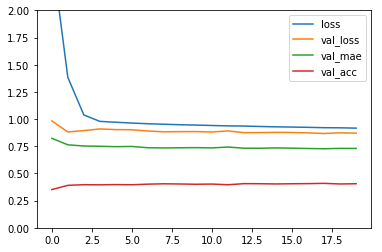

In [6]:
plot(history.history['loss'], label='loss')
plot(history.history['val_loss'], label='val_loss')
plot(history.history['val_mean_absolute_error'], label='val_mae')
plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.ylim(0, 2)

上面的实验结果已经说明了我们构建的深度网络是有效的，接下来我们把网络应用到Bangumi数据集上，并在Bangumi数据集上调参以及尝试更多实验，最后利用我们训练得到的模型来实现一个可用的推荐系统。

经过上面的数据分析，我们发现Bangumi的评分矩阵很稀疏，为了提高模型的准确度，我们这里对数据集做了筛选，过滤掉评分数小于5的用户和被评分数小于5的条目。另外这里把embedding size增加到了500，batch_size设为1000。

In [10]:
# bgm-deep.py
from keras.models import Sequential, Model, Input
from keras.layers import Dot, Dense, Dropout, Embedding, Reshape, Conv1D, MaxPooling1D
from keras.layers.merge import Concatenate
from keras.callbacks import ModelCheckpoint
from keras import metrics, utils, losses
from keras.utils.vis_utils import model_to_dot
from sklearn import metrics as sk_metrics, cross_validation
from IPython.display import SVG
import matplotlib.pyplot as plt
from pylab import plot
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings('ignore')

k1 = 500
k2 = 500
k = k1 + k2
data = pd.read_csv('./bgmdata/new_ratings.txt', sep=' ', engine='python', names=['uid', 'sid', 'rating'])
n_user = data.uid.unique().shape[0]
n_sub = data.sid.unique().shape[0]
print n_user, n_sub

28574 8518


In [4]:
data.head()

,uid,sid,rating
0,0,0,2
1,1,0,8
2,2,0,1
3,3,0,1
4,4,0,6


In [5]:
data.rating.describe()

count    3.131630e+06
mean     7.187196e+00
std      1.513643e+00
min      1.000000e+00
25%      6.000000e+00
50%      7.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

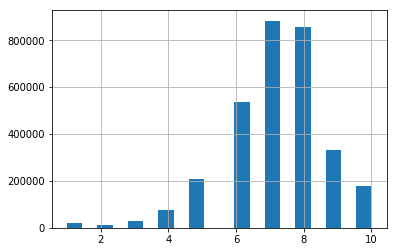

In [6]:
data.rating.hist(bins=20)

In [7]:
data.uid.value_counts().describe()

count    28574.000000
mean       109.597186
std        186.478757
min          3.000000
25%         11.000000
50%         36.000000
75%        131.000000
max       3755.000000
Name: uid, dtype: float64

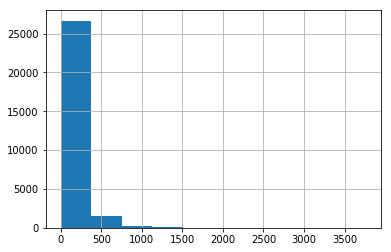

In [8]:
data.uid.value_counts().hist()

In [11]:
input1 = Input(shape=(1,), name='user_input')
model1 = Embedding(n_user, k1, input_length=1)(input1)
model1 = Reshape((k1,))(model1)
input2 = Input(shape=(1,), name='sub_input')
model2 = Embedding(n_sub, k2, input_length=1)(input2)
model2 = Reshape((k2,))(model2)
model = Concatenate()([model1, model2])
model = Dropout(0.2)(model)
model = Dense(k, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(int(k/4), activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(int(k/16), activation='relu')(model)
model = Dropout(0.5)(model)
output = Dense(1, activation='linear')(model)
model = Model([input1, input2], output)
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'acc'])

In [12]:
train, test = cross_validation.train_test_split(data, test_size=0.1, random_state=1)
x_train = [train.uid, train.sid]
y_train = train.rating
x_test = [test.uid, test.sid]
y_test = test.rating
save_path = './save/bgm-deep/'
checkpoint = ModelCheckpoint(save_path + 'best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit(x_train, y_train, batch_size=1000, epochs=20, validation_data=(x_test, y_test), callbacks=callbacks_list)

with open(save_path + 'history.pkl', 'wb') as file_history:
    pickle.dump(history.history, file_history)

Train on 2818467 samples, validate on 313163 samples
Epoch 1/20
2818467/2818467 [==============================] - 96s 34us/step - loss: 2.1129 - mean_absolute_error: 1.1271 - acc: 0.2879 - val_loss: 1.2489 - val_mean_absolute_error: 0.8345 - val_acc: 0.3994

Epoch 00001: val_loss improved from inf to 1.24888, saving model to ./save/bgm-deep/best_model.h5
Epoch 2/20
2818467/2818467 [==============================] - 96s 34us/step - loss: 1.5220 - mean_absolute_error: 0.9379 - acc: 0.3505 - val_loss: 1.1907 - val_mean_absolute_error: 0.8078 - val_acc: 0.4124

Epoch 00002: val_loss improved from 1.24888 to 1.19072, saving model to ./save/bgm-deep/best_model.h5
Epoch 3/20
2818467/2818467 [==============================] - 96s 34us/step - loss: 1.2470 - mean_absolute_error: 0.8319 - acc: 0.4001 - val_loss: 1.1428 - val_mean_absolute_error: 0.7845 - val_acc: 0.42731.2482 - mean_absolute_err - ETA: 1s - loss: 1.2475 - mean_absolute_error

Epoch 00003: val_loss improved from 1.19072 to 1.1428

可以看到训练在第10个epoch达到MSE loss最低，为1.0715，同时MAE为0.757，准确率为44.5%。Bangumi数据集上训练结果略差于mldata上的，这也是预料之中的。实际上这个也是我们最后应用到推荐系统中实际采用的模型。

In [15]:
pd.DataFrame(history.history, columns=['loss', 'val_loss', 'val_mean_absolute_error', 'val_acc']).head(20).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,2.112913,1.522025,1.246980,1.169402,1.125499,1.084342,1.047626,1.014666,0.985963,0.960223,0.938153,0.918107,0.898588,0.882763,0.867806,0.854516,0.841494,0.829973,0.818863,0.810031
val_loss,1.248882,1.190715,1.142809,1.151286,1.113946,1.098996,1.088917,1.086555,1.076530,1.071488,1.072521,1.074528,1.079842,1.074402,1.072412,1.073779,1.078741,1.074797,1.076481,1.076069
val_mean_absolute_error,0.834524,0.807802,0.784514,0.790467,0.772549,0.769567,0.766848,0.766020,0.760865,0.756735,0.758899,0.760097,0.766179,0.757293,0.757064,0.759670,0.761763,0.759236,0.759409,0.759592
val_acc,0.399377,0.412440,0.427349,0.423846,0.437967,0.436460,0.437255,0.438398,0.441342,0.445033,0.443561,0.441974,0.435655,0.444302,0.443989,0.442814,0.440065,0.443596,0.442290,0.441578


(0, 2)

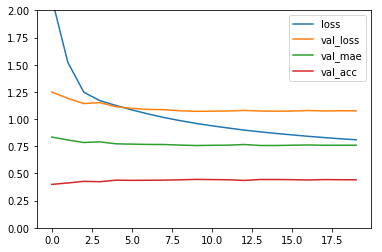

In [19]:
plot(history.history['loss'], label='loss')
plot(history.history['val_loss'], label='val_loss')
plot(history.history['val_mean_absolute_error'], label='val_mae')
plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.ylim(0, 2)

上面的实验都是预测生成一个评分浮点数，下面我们尝试多类预测实验。网络主体框架还是一样的，区别主要在于最后一层的激活函数我们使用softmax函数，对应地loss function选用categorical_crossentropy，然后还需要把评分映射为10个类别。另外这里还加上了top2预测指标。

In [12]:
# bgm-deep-category.py
def acc_top2(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

num_classes = 10
input1 = Input(shape=(1,), name='user_input')
model1 = Embedding(n_user, k1, input_length=1)(input1)
model1 = Reshape((k1,))(model1)
input2 = Input(shape=(1,), name='sub_input')
model2 = Embedding(n_sub, k2, input_length=1)(input2)
model2 = Reshape((k2,))(model2)
model = Concatenate()([model1, model2])
model = Dropout(0.2)(model)
model = Dense(k, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(int(k/4), activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(int(k/16), activation='relu')(model)
model = Dropout(0.5)(model)
output = Dense(num_classes, activation='softmax')(model)
model = Model([input1, input2], output)
model.compile(loss=losses.categorical_crossentropy, optimizer='adam', metrics=['acc', acc_top2])

In [13]:
data.rating = data.rating - 1
train, test = cross_validation.train_test_split(data, test_size=0.1, random_state=1)
x_train = [train.uid, train.sid]
y_train = utils.to_categorical(train.rating, num_classes)
x_test = [test.uid, test.sid]
y_test = utils.to_categorical(test.rating, num_classes)
history = model.fit(x_train, y_train, batch_size=1000, epochs=20, validation_data=(x_test, y_test))

save_path = './save/bgm-deep-category/'
model.save(save_path + 'model.h5')
with open(save_path + 'history.pkl', 'wb') as file_history:
    pickle.dump(history.history, file_history)

Train on 2818467 samples, validate on 313163 samples
Epoch 1/20
2818467/2818467 [==============================] - 99s 35us/step - loss: 1.4411 - acc: 0.4125 - acc_top2: 0.6956 - val_loss: 1.3487 - val_acc: 0.4386 - val_acc_top2: 0.7255
Epoch 2/20
2818467/2818467 [==============================] - 98s 35us/step - loss: 1.3629 - acc: 0.4368 - acc_top2: 0.7225 - val_loss: 1.3327 - val_acc: 0.4434 - val_acc_top2: 0.7304
Epoch 3/20
2818467/2818467 [==============================] - 98s 35us/step - loss: 1.3409 - acc: 0.4441 - acc_top2: 0.7298 - val_loss: 1.3249 - val_acc: 0.4472 - val_acc_top2: 0.7351
Epoch 4/20
2818467/2818467 [==============================] - 98s 35us/step - loss: 1.3233 - acc: 0.4497 - acc_top2: 0.7363 - val_loss: 1.3199 - val_acc: 0.4500 - val_acc_top2: 0.7370
Epoch 5/20
2818467/2818467 [==============================] - 98s 35us/step - loss: 1.3092 - acc: 0.4547 - acc_top2: 0.7414 - val_loss: 1.3167 - val_acc: 0.4527 - val_acc_top2: 0.7391
Epoch 6/20
2818467/2818467 

由于采用了与之前不同的loss function，所以我们不能单纯从测试loss来比对哪个模型的效果更好。不过我在阅读了Kears源码后发现其在计算多类问题的ACC时，是取最大可能值所代表的类来计算的，这样的话这里的ACC与上文的ACC是一致的。我们可以从下面看到在第7个epoch时loss最低，此时ACC为45.5%，比上个实验提升了1%。

In [15]:
pd.DataFrame(history.history, columns=['loss', 'val_loss', 'val_acc', 'val_acc_top2']).head(20).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,1.442217,1.362413,1.340741,1.323254,1.308744,1.296280,1.284801,1.273939,1.263891,1.253617,1.243515,1.234209,1.224607,1.217071,1.208330,1.201145,1.193261,1.186205,1.179431,1.173104
val_loss,1.349114,1.335508,1.324734,1.318383,1.317350,1.316049,1.316939,1.317080,1.317831,1.318514,1.322076,1.324519,1.323687,1.331319,1.337061,1.333806,1.337413,1.344480,1.348490,1.347057
val_acc,0.438273,0.443740,0.448415,0.451113,0.451123,0.452557,0.453515,0.455408,0.457378,0.456922,0.458180,0.457640,0.460693,0.460370,0.460179,0.460856,0.461590,0.462593,0.463960,0.463398
val_acc_top2,0.726376,0.729904,0.734681,0.738264,0.738903,0.740490,0.740656,0.741371,0.742843,0.743606,0.744338,0.745171,0.745708,0.745899,0.747256,0.746902,0.747282,0.747962,0.748300,0.748026


(0, 2)

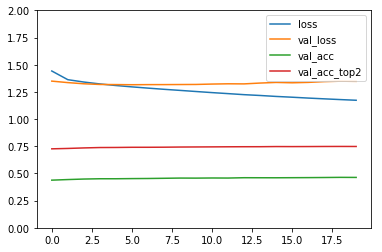

In [22]:
plot(history.history['loss'], label='loss')
plot(history.history['val_loss'], label='val_loss')
plot(history.history['val_acc'], label='val_acc')
plot(history.history['val_acc_top2'], label='val_acc_top2')
plt.legend()
plt.ylim(0, 2)

上面的实验虽然网络结构有区别，但是都是在先对用户和条目生成embedding为基础进行的。但是上文的embedding都是从整理后的用户和条目的id训练而来的，这个id只是一个记号，无法表示这个用户或者这个条目所隐含的属性。而现实中一个用户的喜好往往与他的年龄，性别，阅历等等有关，同样的一个电影的口碑也经常与他的导演，编剧，剧情类型，拍摄国家等等因素挂钩，所以仅仅使用id来代表用户或电影会丢掉很多信息。

考虑到实际Bangumi的情况，我们获取不到更多有用的用户个人信息，但是我们可以从条目的信息着手。Bangumi的每个条目一般都会有其制作公司，导演，脚本以及很多用户根据自己的理解标上的标签等，其中一个标签被标记的用户越多其在条目中显示的位置越靠前。于是我们可以利用条目的标签等信息先生成对应的embedding，之后再用作网络的输入。

我之前在做NLP相关研究时经常使用Word2vec<sup>6</sup>生成词向量，这里的词向量相比于传统的空间向量模型主要优点就在于Word2vec考虑到了词与词之间的关系。Word2vec的思想刚好可以用来解决我们的问题。这里使用Word2vec的变形Doc2vec，区别在于Doc2vec是对一段文字生成其向量表达。

在实际操作的时候，本实验是用每个条目的标签来生成一段文字，其中位置靠前的标签在文本中出现的次数更大。下面是生成向量表示的代码，我们使用了gensim包里的doc2vec实现，embedding size同样设为500。考虑到一个条目的各个标签之间不存在很强的联系，所以这里将window设为了1，同时为了减小噪声我们设置了min_count即标签的最小出现次数。

在生成Doc2vec模型后，接下来的过程与前文类似，这里不再赘述。但是最后的实验结果并没有提升，基本与上文持平。这里的实验我并没有深入研究，就在此停止了。

In [ ]:
# document2vec.py
from gensim.models import doc2vec
documents = doc2vec.TaggedLineDocument('document.txt')
model = doc2vec.Doc2Vec(documents, size=500, window=1, min_count=500, workers=4)
model.save('./document.bin')

最后是利用上文生成的模型来生成推荐。在生成对单个用户的推荐条目时，我们先用模型来预测该用户对每个条目的预测评分，最后按评分高低来排序。但是我在实现Bangumi的推荐系统时，并不是单纯的按评分高低来依次推荐，由于这个不是本文重点，这里略去。

在得到模型之后预测某用户对某条目的评分非常简单，只需要调用接口即可。更有趣的是，我们在训练结束后会得到两个副产品，就是用户和条目的embedding层的参数。前文提到过，利用误差反向传播算法，embedding层的参数也在同时被训练。我们利用得到的参数可以生成相似用户和相似条目，也即“这些用户可能与您有相似的爱好”和“喜欢该条目的用户也喜欢这些条目”。当然，如果我们使用矩阵分解算法，那么会更容易地获得隐含有用户和条目属性的矩阵，同样可以做相似用户和相似条目的推荐。此外我们还可以分析用户以及条目的聚类情况，这个会非常趣。

下面是具体的实现代码，这里我们使用的是余弦距离计算方式。

In [ ]:
# get_user_sub.py
import keras
from keras.models import model_from_json
import numpy as np

def get_recommendation(i, embeddings, top_n, out):
    norms = np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings, axis=1)
    cosine = np.dot(embeddings, embeddings[i]) / norms
    index = np.argsort(-cosine)
    s = ''
    for x in range(top_n):
        if index[x] != i:
            s += str(index[x]) + ',' + str(cosine[index[x]]) + ' '
    s = s[:-1]
    out.write(s + '\n')

model = keras.models.load_model('./save/train/model.h5')
weights = model.get_weights()
user_embeddings = weights[0]
sub_embeddings = weights[1]
n_user = 28574
n_sub = 8518
out = open('./user_recommend.txt', 'w')
for i in range(n_user):
    get_recommendation(i, user_embeddings, 100, out)
out.close()
out = open('./sub_recommend.txt', 'w')
for i in range(n_sub):
    get_recommendation(i, sub_embeddings, 50, out)
out.close()

这样其实我们已经做完了所有的实验。我也简单检查了一下系统为我生成的推荐结果以及推荐的相似条目等，大体上比较满意。但是上文也提到了我在实际编写推荐系统时还加入了很多别的考量，其中我就加入了“相似条目”这一项，这里的“相似条目”与上文中用模型生成的“喜欢该条目的用户也喜欢这些条目”是两个概念。

我调研了包括国内的豆瓣，哔哩哔哩弹幕网，淘宝以及国外的MyAnimelist，anidb，IMDB，Amazon等网站的推荐系统，有使用协同过滤推荐的，也有基于内容来推荐的。就我观察来看，总体来说前者推荐的结果不容易让用户看到推荐结果与原条目之间的关联，当然这也是算法的重点在于挖掘隐含的评分联系所导致的。比如豆瓣里对于[冰菓](https://movie.douban.com/subject/10001418/)的推荐结果前三个分别是[化物语](https://movie.douban.com/subject/3893384/)、[伪物语](https://movie.douban.com/subject/6852358/)和[魔法少女小圆](https://movie.douban.com/subject/5349275/)，显然后三者的类型看不出来与前者有表面上的联系，但是给冰菓打高分的用户确实很有可能也给这三者打高分。问题这个推荐结果是否能说服用户，让用户去观看这些推荐的作品。而基于内容推荐的思想很简单，却很实用，主要是会推荐一些有相同的属性的物品。比如哔哩哔哩弹幕网上对于[青之花](https://www.bilibili.com/bangumi/media/md1146)的推荐结果为[轻声密语](https://www.bilibili.com/bangumi/play/ss1166)、[樱Trick](https://www.bilibili.com/bangumi/play/ss3547)、[CANDY BOY](https://www.bilibili.com/bangumi/play/ss1789)和[citrus～柑橘味香气～](https://www.bilibili.com/bangumi/play/ss21557)，这些推荐显然就有了更强的说服力。

这两种推荐结果各有优缺点，我在提供上述“可能喜欢”的推荐结果时，也推荐了那些在属性上更加相似的条目。下面是实现代码，具体思想就是构建条目-标签无向图，每个条目与其每个关联的标签都有一条无向边，其权重取决于该标签在条目页的位置（即被认可程度）。我们定义两个条目的相似度为这两个条目所有只包含单个标签连通路径上权重的较小值之和。

这个算法思想很简单，写起来也很容易。利用有用标签数远远少于条目数这一特性，我们可以做很多优化。如果用$N$表示条目数，$M$表示标签总数，$m$表示平均每个条目的标签数，算法复杂度的计算主要有三个部分，一个是把条目-标签的关联方式转换成标签-条目的方式，这一部分复杂度是$O(NM)$；第二部分是计算每两对条目之间的相似度，这个我们可以优化到$O(\frac{N^{2}m^{2}}{M})$；第三部分是对每个条目生成推荐列表，涉及到排序问题，这部分复杂度的计算关键在于平均每个条目与多少条目存在关联，实际上利用第二部分得到的$\frac{N^{2}m^{2}}{M}$除以$N$就可以得到，因此第三部分的复杂度为$O(\frac{N^{2}m^{2}}{M}log\frac{Nm^{2}}{M})$。这个复杂度其实是很低的，因此程序的运算速度很快，如果把这个当做算法竞赛题然后用C++来写，再做一些输入输出优化的话，应该可以做到几秒钟出结果。

In [ ]:
# item.py
import json
import numpy as np

f = open('./item.txt')
out = open('./item_recommend.txt', 'w')
lines = f.readlines()
n = len(lines) - 1
m = int(lines[0].strip('\n'))
print n, m
tag_mtx = [[] for i in range(m)]
for i in range(1, n + 1):
    line = lines[i].strip('\n')
    line = line.split(' ')
    for x in line:
        x = x.split(',')
        tag_mtx[int(x[1])].append([i - 1, int(x[0])])
print 'start calculate'
sub_mtx = [{} for i in range(n)]
for tag in tag_mtx:
    for x in tag:
        for y in tag:
            if x == y:
                continue
            if y[0] not in sub_mtx[x[0]]:
                sub_mtx[x[0]][y[0]] = min(x[1], y[1])
            else:
                sub_mtx[x[0]][y[0]] += min(x[1], y[1])
print 'start recommend'
for i in range(n):
    sub_mtx[i] = sorted(sub_mtx[i].items(), key=lambda x: x[1], reverse=True)
    sub_mtx[i] = sub_mtx[i][:50]
    s = ''
    for x in sub_mtx[i]:
        s += str(x[0]) + ',' + str(x[1]) + ' '
    s = s[:-1]
    out.write(s + '\n')
out.close()

参考文献

[1] Adomavicius G, Tuzhilin A. Toward the next generation of recommender systems: A survey of the state-of-the-art and possible extensions[J]. IEEE transactions on knowledge and data engineering, 2005, 17(6): 734-749.

[2] Wall M E, Rechtsteiner A, Rocha L M. Singular value decomposition and principal component analysis[M]//A practical approach to microarray data analysis. Springer, Boston, MA, 2003: 91-109.

[3] 马小栓. 矩阵分解在推荐系统中的研究与应用[D].电子科技大学,2017.

[4] https://grouplens.org/datasets/movielens/1m/

[5] http://www.mymedialite.net/examples/datasets.html

[6] MIKOLOV T, SUTSKEVER I, CHEN K, et al. Distributed Representations of Words and Phrases and Their Compositionality[A] Advances in Neural Information Processing Systems[C], 2013: 3111-3119.

另外本文中的一些表述和算法设计灵感参考了很多书籍和博客，在此不再一一列出。